Loading data...
Preprocessing data...
Running simple basket analysis...
Analyzing profitability...
Analyzing sales patterns by time...
Creating visualizations...


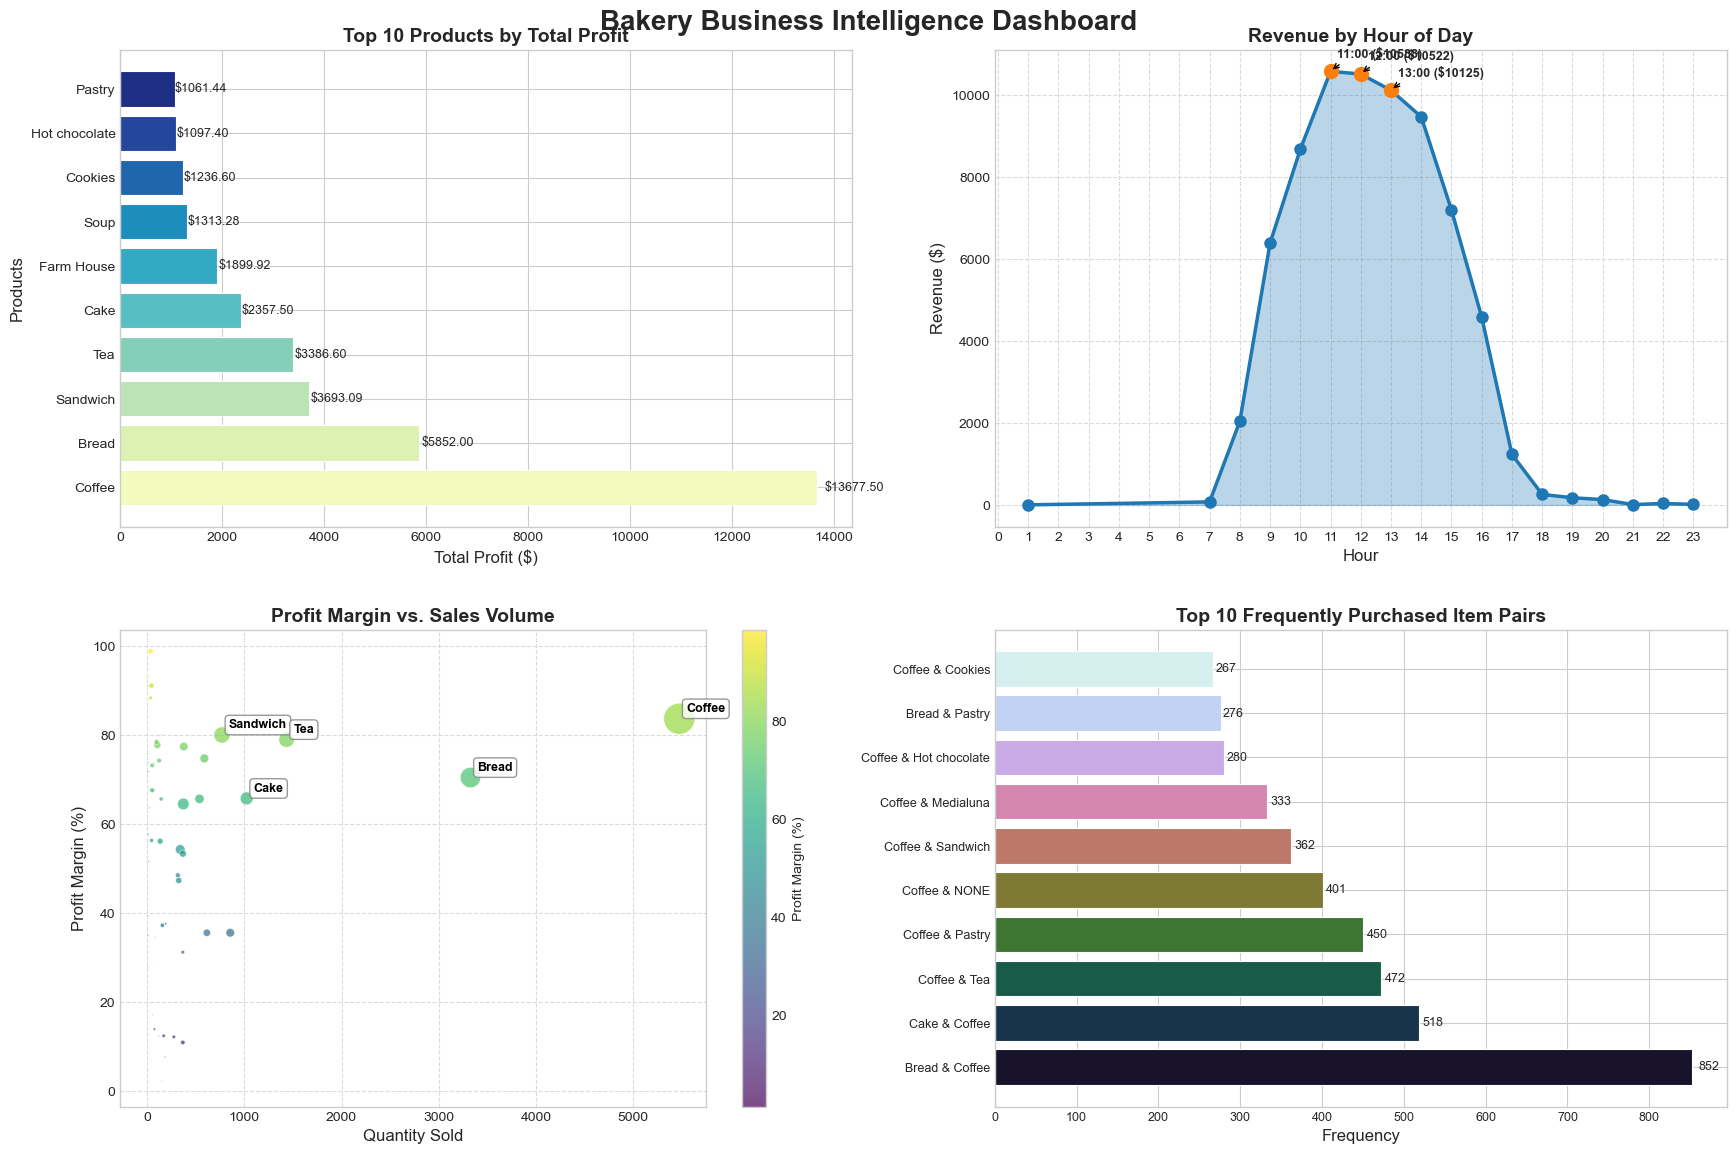


KEY FINDINGS:

Top 5 Most Profitable Products:
          Total Profit  Profit Margin  Quantity Sold
Item                                                
Coffee        13677.50      83.612040           5471
Bread          5852.00      70.400000           3325
Sandwich       3693.09      79.966611            771
Tea            3386.60      78.929766           1435
Cake           2357.50      65.714286           1025

Top 5 Item Pairs:
     Item1   Item2  Frequency
4    Bread  Coffee        852
97    Cake  Coffee        518
12  Coffee     Tea        472
3   Coffee  Pastry        450
36  Coffee    NONE        401

Peak Sales Hours:
      Transaction Count   Revenue
Hour                             
11                 1445  10588.45
12                 1347  10522.42
13                 1163  10125.34

Analysis complete! Check the visualization file for more insights.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Load data
def load_data(file_path):
    # Read both sheets
    transactions_df = pd.read_excel(file_path, sheet_name=0)
    costs_df = pd.read_excel(file_path, sheet_name=1)
    
    # Make sure Item names are consistent between the two sheets
    transactions_df['Item'] = transactions_df['Item'].str.strip()
    costs_df['Item'] = costs_df['Item'].str.strip()
    
    return transactions_df, costs_df

# Part 1: Data Preprocessing
def preprocess_data(transactions_df, costs_df):
    # Convert date and time to datetime
    if 'Date' in transactions_df.columns and 'Time' in transactions_df.columns:
        transactions_df['DateTime'] = pd.to_datetime(
            transactions_df['Date'].astype(str) + ' ' + transactions_df['Time'].astype(str)
        )
        
        # Extract useful time components
        transactions_df['Hour'] = transactions_df['DateTime'].dt.hour
        transactions_df['DayOfWeek'] = transactions_df['DateTime'].dt.dayofweek
        transactions_df['Month'] = transactions_df['DateTime'].dt.month
        transactions_df['DayName'] = transactions_df['DateTime'].dt.day_name()
    
    # Add cost data to transactions
    merged_df = pd.merge(transactions_df, costs_df, on='Item', how='left')
    
    # Calculate profit for each transaction
    if 'Sale Price' in merged_df.columns and 'Our Cost' in merged_df.columns:
        merged_df['Profit'] = merged_df['Sale Price'] - merged_df['Our Cost']
        merged_df['Margin'] = (merged_df['Profit'] / merged_df['Sale Price']) * 100
    
    return merged_df

# Part 2: Simple Basket Analysis (without mlxtend)
def simple_basket_analysis(transactions_df):
    # Look at item pairs within the same transaction
    all_item_pairs = []
    
    # Group by transaction
    transaction_groups = transactions_df.groupby('Transaction')
    
    # For each transaction, create all possible pairs of items
    for transaction_id, group in transaction_groups:
        items = group['Item'].unique()
        if len(items) > 1:  # Only consider transactions with at least 2 items
            for i in range(len(items)):
                for j in range(i+1, len(items)):
                    all_item_pairs.append((items[i], items[j]))
    
    # Count frequency of each pair
    pair_counts = {}
    for pair in all_item_pairs:
        # Sort pair to ensure consistent ordering
        sorted_pair = tuple(sorted(pair))
        if sorted_pair in pair_counts:
            pair_counts[sorted_pair] += 1
        else:
            pair_counts[sorted_pair] = 1
    
    # Convert to dataframe
    pairs_df = pd.DataFrame(list(pair_counts.items()), columns=['Pair', 'Frequency'])
    pairs_df['Item1'] = pairs_df['Pair'].apply(lambda x: x[0])
    pairs_df['Item2'] = pairs_df['Pair'].apply(lambda x: x[1])
    pairs_df = pairs_df.sort_values('Frequency', ascending=False)
    
    return pairs_df[['Item1', 'Item2', 'Frequency']]

# Part 3: Profitability Analysis
def profitability_analysis(merged_df):
    # Analyze profitability by item
    profit_by_item = merged_df.groupby('Item').agg({
        'Sale Price': 'first',
        'Our Cost': 'first',
        'Transaction': 'count'
    }).rename(columns={'Transaction': 'Quantity Sold'})
    
    profit_by_item['Total Revenue'] = profit_by_item['Sale Price'] * profit_by_item['Quantity Sold']
    profit_by_item['Total Cost'] = profit_by_item['Our Cost'] * profit_by_item['Quantity Sold']
    profit_by_item['Total Profit'] = profit_by_item['Total Revenue'] - profit_by_item['Total Cost']
    profit_by_item['Profit Margin'] = (profit_by_item['Total Profit'] / profit_by_item['Total Revenue']) * 100
    
    return profit_by_item.sort_values('Total Profit', ascending=False)

# Part 4: Time-Based Analysis
def time_analysis(merged_df):
    # Sales by hour of day
    hourly_sales = merged_df.groupby('Hour').agg({
        'Transaction': 'nunique',
        'Sale Price': 'sum'
    }).rename(columns={'Transaction': 'Transaction Count', 'Sale Price': 'Revenue'})
    
    # Sales by day of week
    daily_sales = merged_df.groupby('DayName').agg({
        'Transaction': 'nunique',
        'Sale Price': 'sum'
    }).rename(columns={'Transaction': 'Transaction Count', 'Sale Price': 'Revenue'})
    
    # Items sold by hour (top 5 items for each hour)
    items_by_hour = {}
    for hour in sorted(merged_df['Hour'].unique()):
        hour_data = merged_df[merged_df['Hour'] == hour]
        top_items = hour_data['Item'].value_counts().head(5)
        items_by_hour[hour] = top_items
    
    return hourly_sales, daily_sales, items_by_hour

# Part 5: Create Visualizations (IMPROVED VERSION)
def create_visualizations(merged_df, profit_by_item, hourly_sales, daily_sales, pairs_df):
    # Set aesthetics for better visualizations
    plt.style.use('seaborn-v0_8-whitegrid')  # Modern style
    sns.set_palette("viridis")  # Use a nicer color palette
    
    # Define custom colors for various plots
    top_profit_color = sns.color_palette("YlGnBu", 10)
    time_colors = sns.color_palette("RdYlBu", 24)
    scatter_colors = sns.color_palette("plasma", 10)
    pairs_colors = sns.color_palette("cubehelix", 10)
    
    # Create figure with improved layout
    fig = plt.figure(figsize=(18, 12))
    
    # 1. Top Products by Profit - Improved
    ax1 = fig.add_subplot(2, 2, 1)
    top_profits = profit_by_item.head(10)
    bars = ax1.barh(top_profits.index, top_profits['Total Profit'], 
                   color=top_profit_color, edgecolor='white', linewidth=0.8)
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        label_x_pos = width * 1.01
        ax1.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'${width:.2f}',
                 va='center', fontsize=9)
    
    ax1.set_title('Top 10 Products by Total Profit', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Total Profit ($)', fontsize=12)
    ax1.set_ylabel('Products', fontsize=12)
    ax1.tick_params(axis='both', labelsize=10)
    
    # 2. Hourly Sales Pattern - Improved
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.plot(hourly_sales.index, hourly_sales['Revenue'], marker='o', 
             color='#1f77b4', linewidth=2.5, markersize=8)
    
    # Fill under the curve with gradient
    ax2.fill_between(hourly_sales.index, hourly_sales['Revenue'], 
                    color='#1f77b4', alpha=0.3)
    
    # Highlight peak hours
    peak_hours = hourly_sales.nlargest(3, 'Revenue')
    ax2.scatter(peak_hours.index, peak_hours['Revenue'], color='#ff7f0e', 
                s=100, label='Peak Hours', zorder=3)
    
    for idx, row in peak_hours.iterrows():
        ax2.annotate(f"{idx}:00 (${row['Revenue']:.0f})", 
                     (idx, row['Revenue']), 
                     xytext=(5, 10), textcoords='offset points',
                     fontsize=9, fontweight='bold',
                     arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))
    
    ax2.set_title('Revenue by Hour of Day', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Hour', fontsize=12)
    ax2.set_ylabel('Revenue ($)', fontsize=12)
    ax2.set_xticks(range(0, 24))
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.tick_params(axis='both', labelsize=10)
    
    # 3. Profit Margin vs. Volume - Improved
    ax3 = fig.add_subplot(2, 2, 3)
    
    # Calculate size for scatter points normalized by total profit
    max_profit = profit_by_item['Total Profit'].max()
    sizes = profit_by_item['Total Profit'] / max_profit * 500
    
    # Create colormap based on profit margin
    norm = plt.Normalize(profit_by_item['Profit Margin'].min(), profit_by_item['Profit Margin'].max())
    
    # Create scatter plot with better aesthetics
    scatter = ax3.scatter(profit_by_item['Quantity Sold'], profit_by_item['Profit Margin'],
                         alpha=0.7, s=sizes, c=profit_by_item['Profit Margin'], 
                         cmap='viridis', norm=norm, edgecolors='white', linewidth=0.5)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label('Profit Margin (%)', fontsize=10)
    
    # Add labels for top profit items with improved styling
    for idx, row in profit_by_item.head(5).iterrows():
        ax3.annotate(idx, 
                    (row['Quantity Sold'], row['Profit Margin']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, fontweight='bold', color='black',
                    bbox=dict(boxstyle="round,pad=0.3", fc='white', ec="gray", alpha=0.8))
    
    ax3.set_title('Profit Margin vs. Sales Volume', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Quantity Sold', fontsize=12)
    ax3.set_ylabel('Profit Margin (%)', fontsize=12)
    ax3.grid(True, linestyle='--', alpha=0.7)
    ax3.tick_params(axis='both', labelsize=10)
    
    # 4. Top Item Pairs - Improved
    ax4 = fig.add_subplot(2, 2, 4)
    top_pairs = pairs_df.head(10)
    pair_labels = [f"{row['Item1']} & {row['Item2']}" for _, row in top_pairs.iterrows()]
    
    # Generate gradient colors for bars
    bars = ax4.barh(pair_labels, top_pairs['Frequency'], 
                   color=pairs_colors, edgecolor='white', linewidth=0.8)
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        label_x_pos = width * 1.01
        ax4.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.0f}',
                 va='center', fontsize=9)
    
    ax4.set_title('Top 10 Frequently Purchased Item Pairs', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Frequency', fontsize=12)
    ax4.tick_params(axis='both', labelsize=9)
    
    # Improve overall layout
    plt.tight_layout(pad=3.0)
    fig.suptitle('Bakery Business Intelligence Dashboard', fontsize=20, fontweight='bold', y=0.98)
    
    # Save with higher quality
    plt.savefig('bakery_analysisSJ.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return 'bakery_analysis.png'

# Part 6: Main Function to Run the Analysis
def run_bakery_analysis(file_path):
    # Load and preprocess data
    print("Loading data...")
    transactions_df, costs_df = load_data(file_path)
    
    print("Preprocessing data...")
    merged_df = preprocess_data(transactions_df, costs_df)
    
    # Run analyses
    print("Running simple basket analysis...")
    pairs_df = simple_basket_analysis(transactions_df)
    
    print("Analyzing profitability...")
    profit_by_item = profitability_analysis(merged_df)
    
    print("Analyzing sales patterns by time...")
    hourly_sales, daily_sales, items_by_hour = time_analysis(merged_df)
    
    print("Creating visualizations...")
    viz_file = create_visualizations(merged_df, profit_by_item, hourly_sales, daily_sales, pairs_df)
    
    # Return all analysis results
    results = {
        'merged_data': merged_df,
        'item_pairs': pairs_df,
        'profitability': profit_by_item,
        'hourly_sales': hourly_sales,
        'daily_sales': daily_sales,
        'items_by_hour': items_by_hour,
        'visualization_file': viz_file
    }
    
    return results

# Run the analysis
if __name__ == "__main__":
    # Replace with your file path
    file_path = 'BreadBasketT.xlsx'
    results = run_bakery_analysis(file_path)
    
    # Print key findings
    print("\nKEY FINDINGS:")
    print("\nTop 5 Most Profitable Products:")
    print(results['profitability'][['Total Profit', 'Profit Margin', 'Quantity Sold']].head(5))
    
    print("\nTop 5 Item Pairs:")
    print(results['item_pairs'].head(5))
    
    print("\nPeak Sales Hours:")
    print(results['hourly_sales'].sort_values('Revenue', ascending=False).head(3))
    
    print("\nAnalysis complete! Check the visualization file for more insights.")